# Functions for creating automatic CSV files

In [10]:
import numpy as np
#!pip install cantera
import matplotlib.pyplot as plt
import cantera as ct
#import csv
import pandas as pd
from csv import reader  # for reading csv files
from csv import writer  # for writing csv files
from os import listdir
from os.path import isfile, join

First, we are going to create files that will read temperature and mass fractions, and compute the net production reaction rate from Cantera

In [2]:
def compute_reaction_rate(name_file, path):
    species_names=pd.read_csv(path+name_file, header=0, nrows=0).columns.tolist()
    z_columns=[]
    z_keys=[]
    for i in range(0,len(species_names)):
        if species_names[i].split('_')[0]=="Species":
            z_columns.append(species_names[i])
            z_keys.append(species_names[i].split('_')[1])
    z_keys.append('N2')
    mass_fractions=species_names=pd.read_csv(path+name_file, usecols=z_columns).values
    temperatures=pd.read_csv(path+name_file, usecols=["Temperature"]).values
    gas_set = ct.Solution("h2o2.yaml", "ohmech", "mixture-averaged")
    with open('Reaction_rates_'+name_file, 'w', newline='\n') as write_obj:
        reaction_rates=[]
        for i in range(0,np.shape(temperatures)[0]):
            mass_fraction=mass_fractions[i].tolist()
            species_sum=0
            for j in range(0,len(mass_fraction)):
                species_sum+=mass_fraction[j]
            mass_fraction.append(1.0-species_sum)
            chemical_composition=dict(zip(z_keys,mass_fraction))
            gas_set.TPY=float(temperatures[i]), 101325, chemical_composition
            net_production_rates=[gas_set.net_production_rates[k]*gas_set.molecular_weights[k] for k in range(0,len(mass_fraction))]
            if i==0:
                chemical_names=["Source_"+gas.species_name(k) for k in range(0,len(mass_fraction))]
                list_to_write=["Temperature"]+chemical_names
                writer(write_obj).writerow(list_to_write)
            list_to_write=[gas_set.T]+net_production_rates
            writer(write_obj).writerow(list_to_write)
        

we test the function created above for a single data set

In [212]:
compute_reaction_rate("slice_0001.csv", "/home/cristopher/Python_scripts_for_computing_physical_quantities/data 2D burner/data 2D burner hydrogen/")

Using the function compute_reaction_rate, we are going to create several csv files that read data file at several y-position and compute the reaction rates

In [213]:
def create_csv_file(path):
    directory=path
    file_list=[f for f in listdir(path) if isfile(join(directory,f))]
    for file in file_list:
        compute_reaction_rate(file,path)

We can test how the function above works

In [214]:
create_csv_file("/home/cristopher/Python_scripts_for_computing_physical_quantities/data 2D burner/data 2D burner hydrogen/")

# Creating a function for automatic plots

In [8]:
def plot_function(x, y, **kwargs):
    title  = kwargs.pop( 'title'  )
    xlabel = kwargs.pop( 'xlabel' )
    ylabel = kwargs.pop( 'ylabel' )
    plt.figure(figsize=(8,6))
    plt.plot(x, y,'go',markersize=8, label=title)
    plt.legend(loc='upper right')
    fig = plt.gcf()
    for axis in fig.axes:
        axis.xaxis.set_label_text( xlabel )
        axis.yaxis.set_label_text( ylabel )
    return axis

Testing the above function for a data set

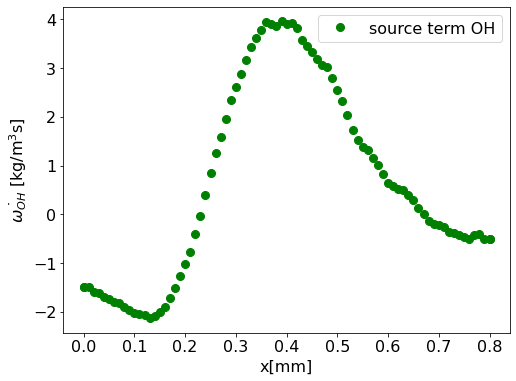

In [9]:
path="/home/cristopher/Python_scripts_for_computing_physical_quantities/data 2D burner/data 2D burner hydrogen/"
x=pd.read_csv(path+"slice_0001.csv", usecols=["Points_0"]).values
y=pd.read_csv("/home/cristopher/"+"Reaction_rates_slice_0001.csv", usecols=["Source_OH"]).values
x_scale=[1000*i[0] for i in x ]
y_axis="$\dot{\omega_{OH}}$ [kg/m$^{3}$s]"
plot_conf = {'title': "source term OH", 'xlabel':'x[mm]', 'ylabel': y_axis}
axis=plot_function(x_scale,y,**plot_conf)

Using the plot_function, we are going to create a function for making several plots that will retrieve the chemical source term for a specific chemical species at  different y-positions.

In [16]:
def make_plots_source(species, path):
    file_list=[f for f in listdir(path) if f.split('.')[-1]=='csv' and f.split('_')[0]=='Reaction']
    y_axis="$\dot{\omega}_{"+species+"}$ [kg/m$^{3}$s]"
    x_axis="x[mm]"
    for file in file_list:
        path_original="/home/cristopher/Python_scripts_for_computing_physical_quantities/data 2D burner/data 2D burner hydrogen/"
        file_x=file.split('_')[2]+"_"+file.split('_')[3]
        x=pd.read_csv(path_original+file_x, usecols=["Points_0"]).values
        y=pd.read_csv(path+file, usecols=["Source_"+species]).values
        x_scale=[1000*i[0] for i in x ]
        n=len(file.split('_')[3].split('.')[0].split('000')[1])
        title= int(file.split('_')[3].split('.')[0])/10**(n-1) 
        plot_conf = {'title': "y="+str(title)+"[mm]", 'xlabel':'x[mm]', 'ylabel': y_axis}
        axis=plot_function(x_scale,y,**plot_conf)

Testing the above function for $Y_{OH}[-]$ for plotting $\dot{\omega}_{Y_{OH}}$ [kg/m$^{3}$s]$

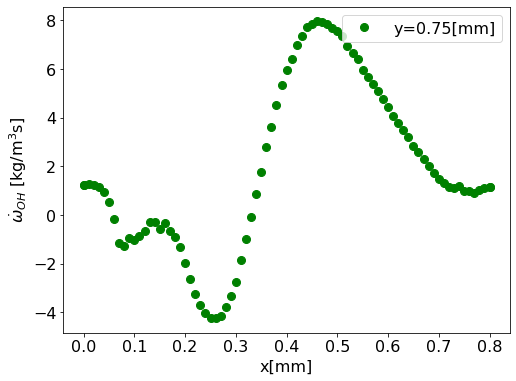

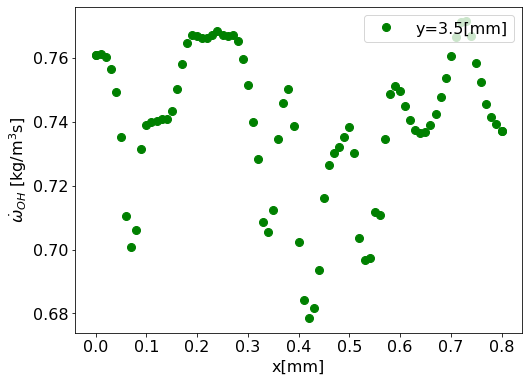

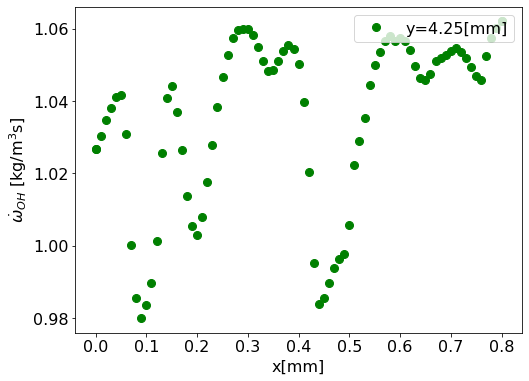

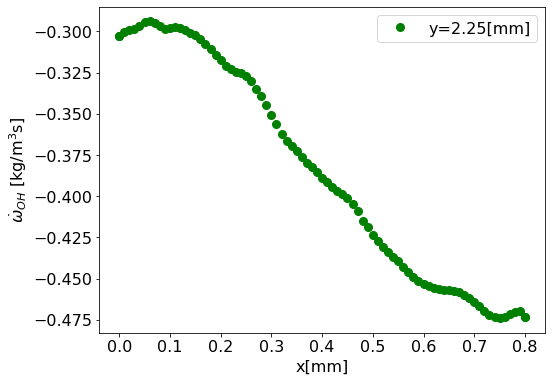

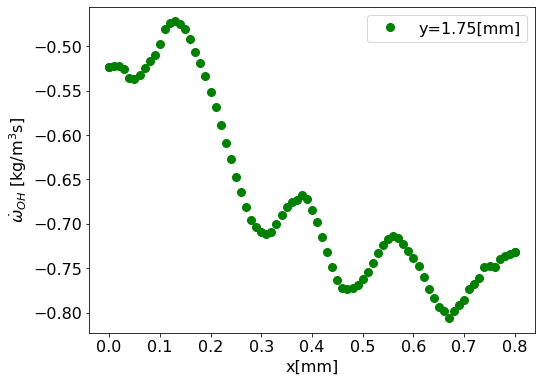

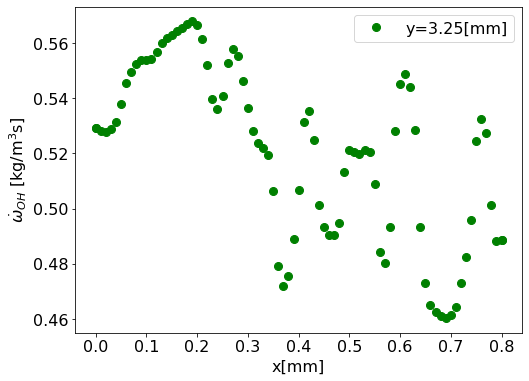

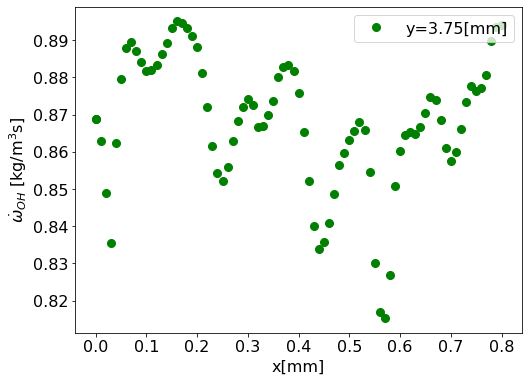

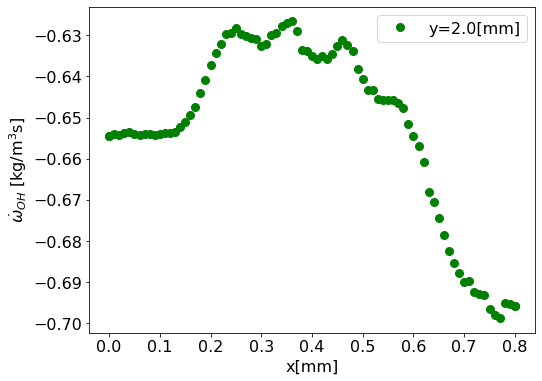

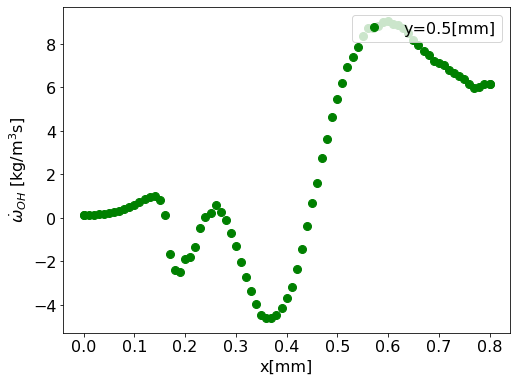

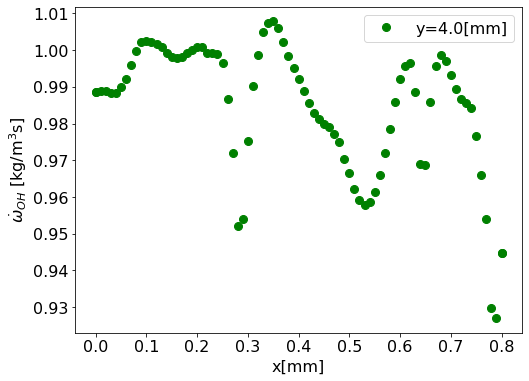

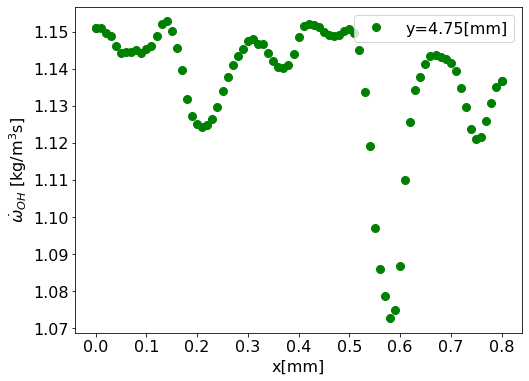

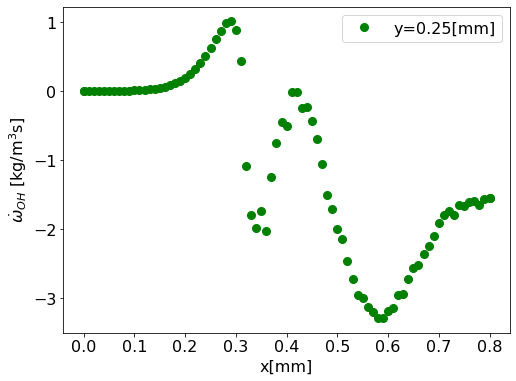

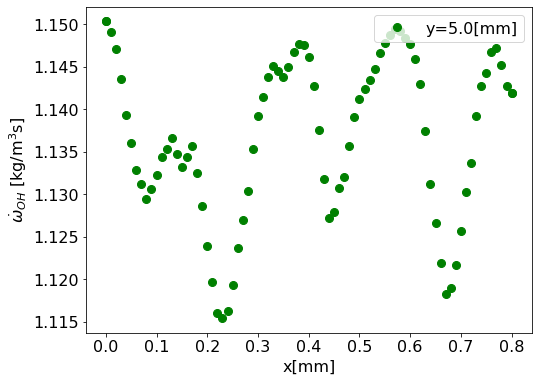

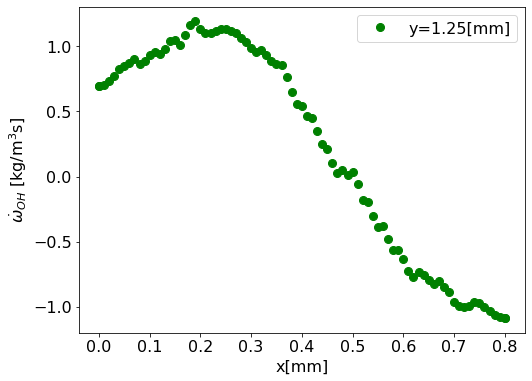

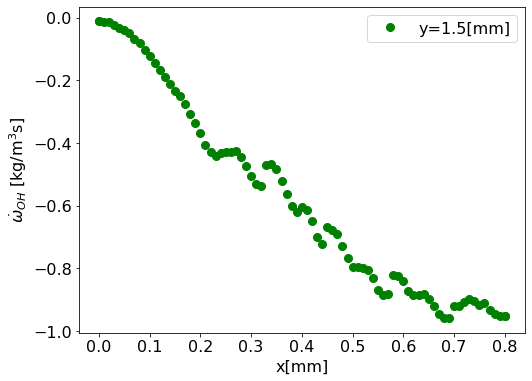

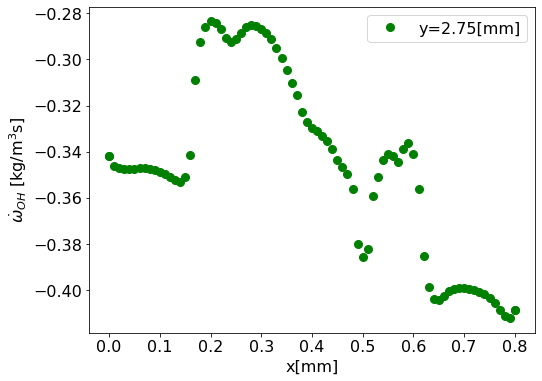

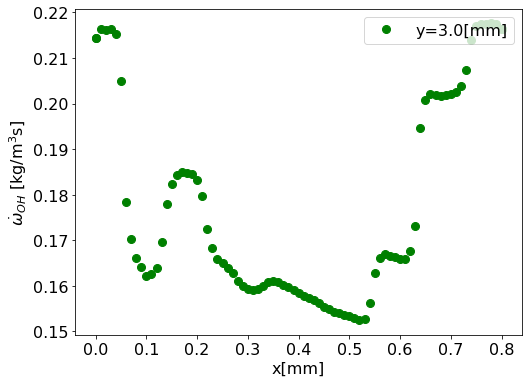

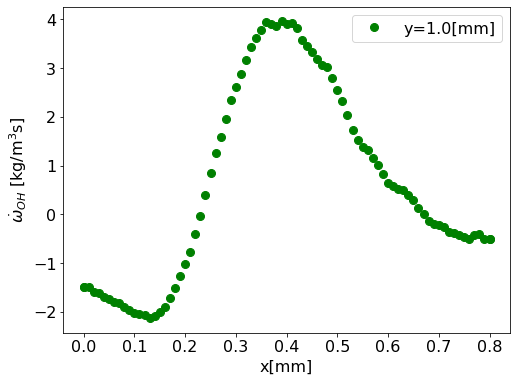

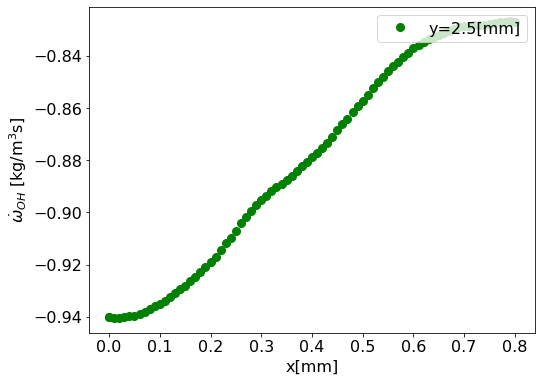

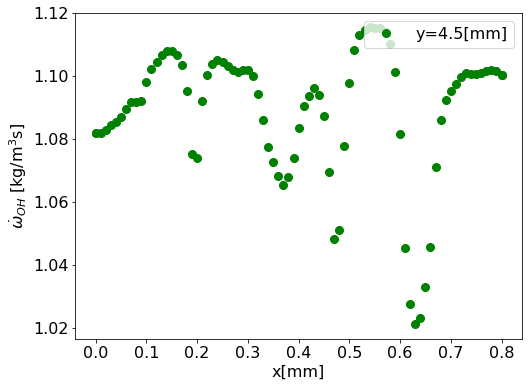

In [17]:
make_plots_source("OH","/home/cristopher/")

# Create a plot for temperature at different $y$-locations

In [50]:
def make_plots_temperature(path):
    file_list=[f for f in listdir(path) if f.split('.')[-1]=='csv' and f.split('_')[0]=='slice']
    y_axis="$T$[K]"
    x_axis="x[mm]"
    for file in file_list:
        x=pd.read_csv(path+file, usecols=["Points_0"]).values
        y=pd.read_csv(path+file, usecols=["Temperature"]).values
        x_scale=[1000*i[0] for i in x ]
        n=len(file.split('_')[1].split('.')[0].split('000')[1])
        title= int(file.split('_')[1].split('.')[0])/10**(n-1) 
        plot_conf = {'title': "y="+str(title)+"[mm]", 'xlabel':'x[mm]', 'ylabel': y_axis}
        axis=plot_function(x_scale,y,**plot_conf)

Testing above function

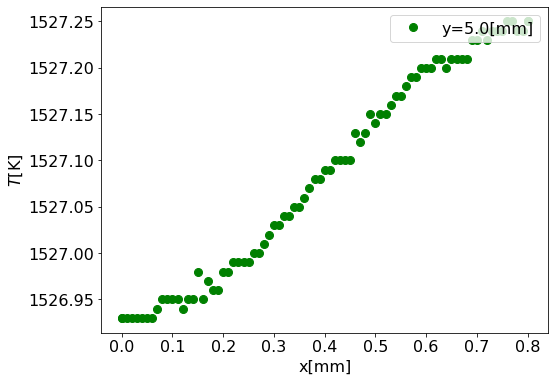

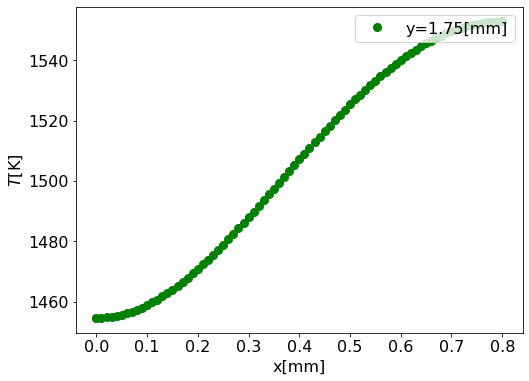

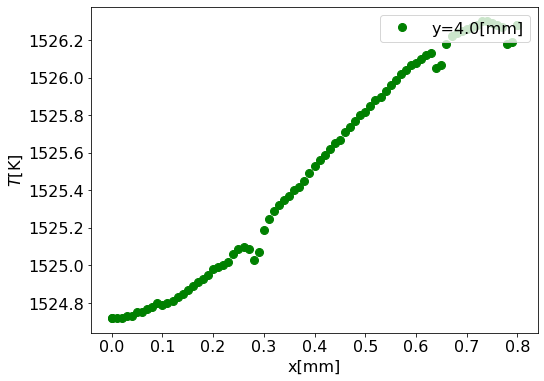

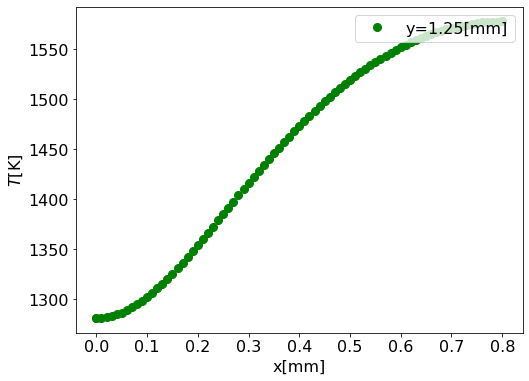

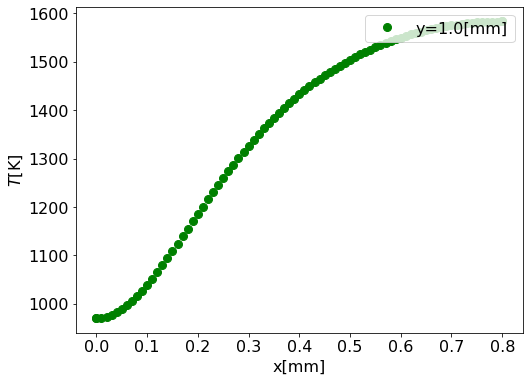

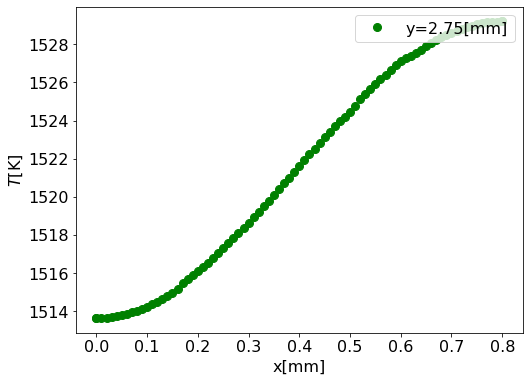

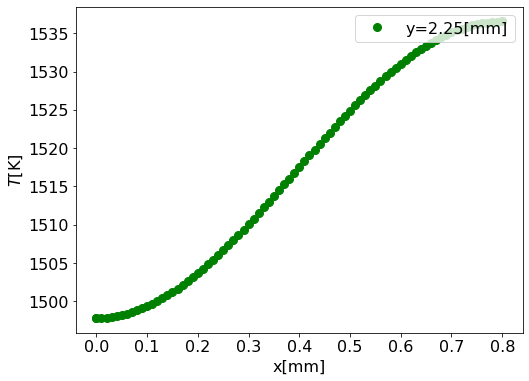

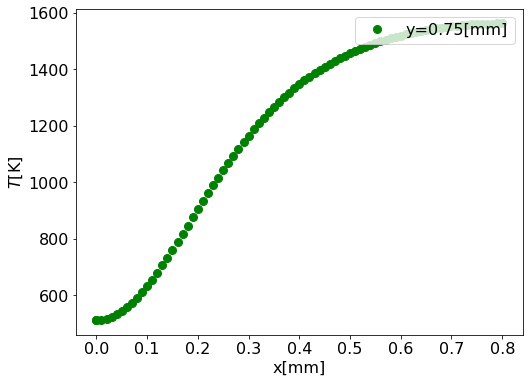

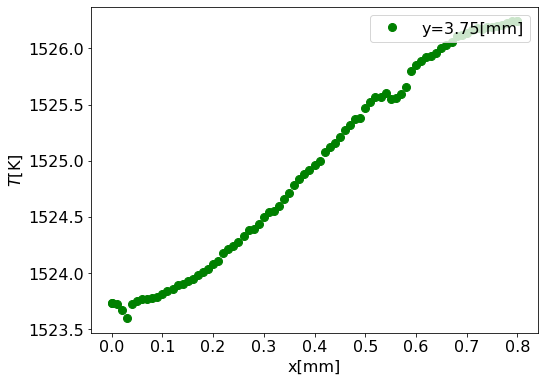

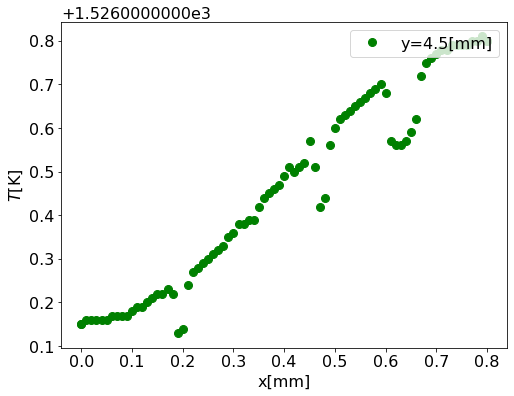

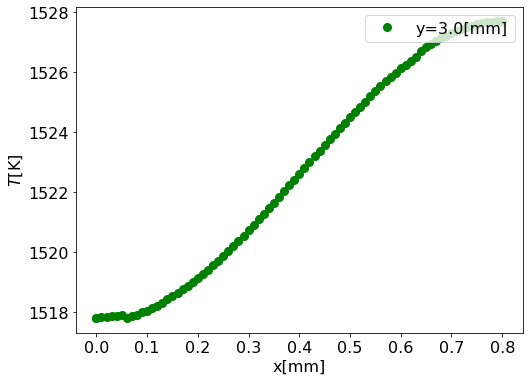

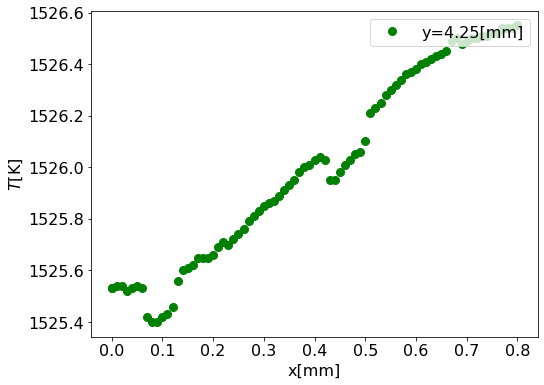

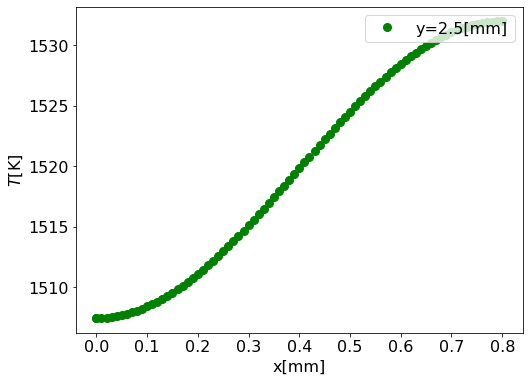

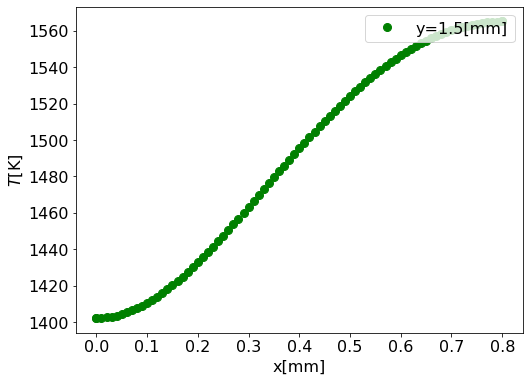

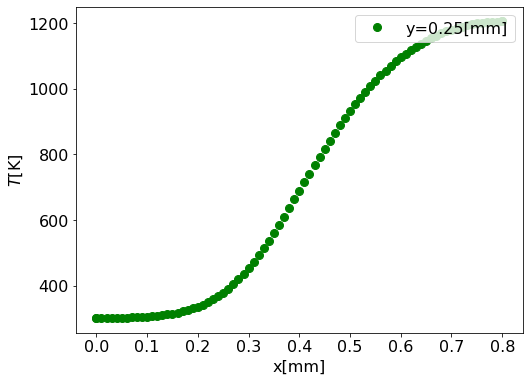

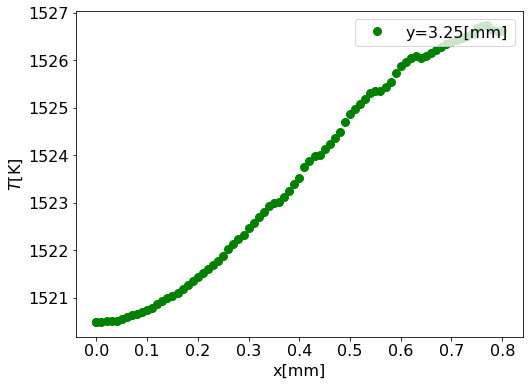

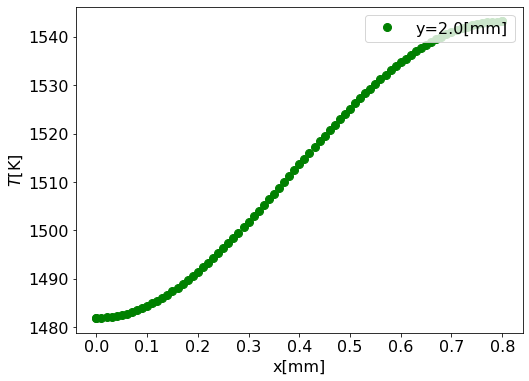

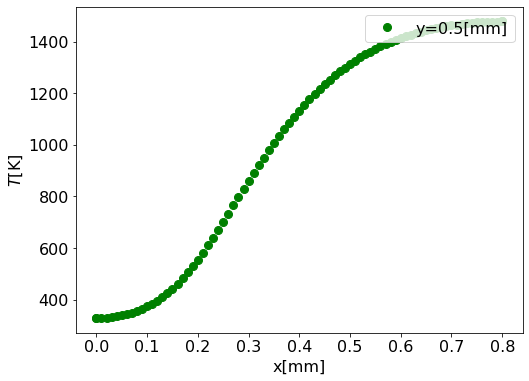

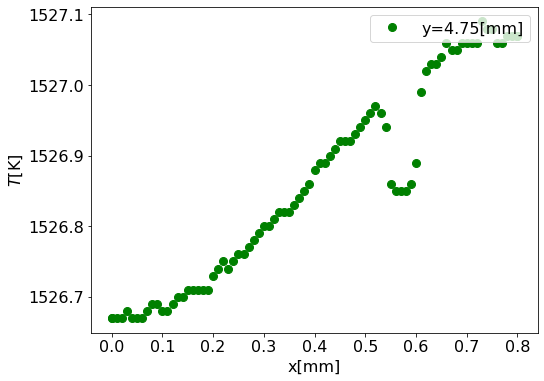

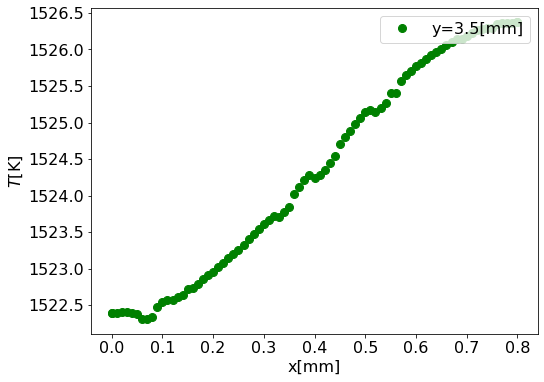

In [51]:
make_plots_temperature("/home/cristopher/Python_scripts_for_computing_physical_quantities/data 2D burner/data 2D burner hydrogen/")

# Function for species mass fraction $y[-]$

In [39]:
def make_plots_massfraction(species,path):
    file_list=[f for f in listdir(path) if f.split('.')[-1]=='csv' and f.split('_')[0]=='slice']
    y_axis="$Y_{"+species+"}$[-]"
    x_axis="x[mm]"
    for file in file_list:
        x=pd.read_csv(path+file, usecols=["Points_0"]).values
        y=pd.read_csv(path+file, usecols=["Species_"+species]).values
        x_scale=[1000*i[0] for i in x ]
        n=len(file.split('_')[1].split('.')[0].split('000')[1])
        title= int(file.split('_')[1].split('.')[0])/10**(n-1) 
        plot_conf = {'title': "y="+str(title)+"[mm]", 'xlabel':'x[mm]', 'ylabel': y_axis}
        axis=plot_function(x_scale,y,**plot_conf)

Testing above function

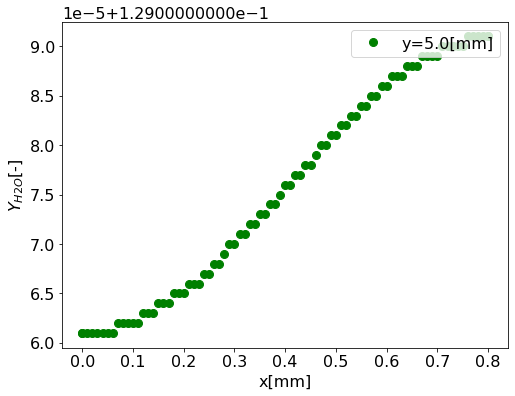

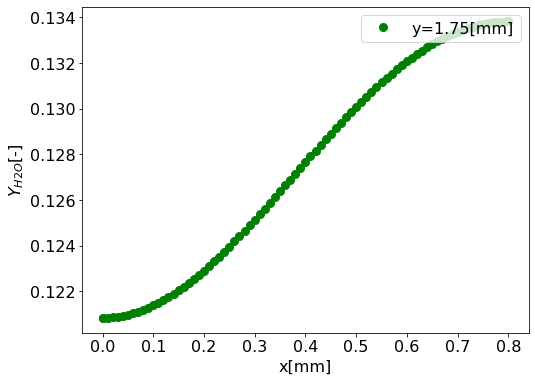

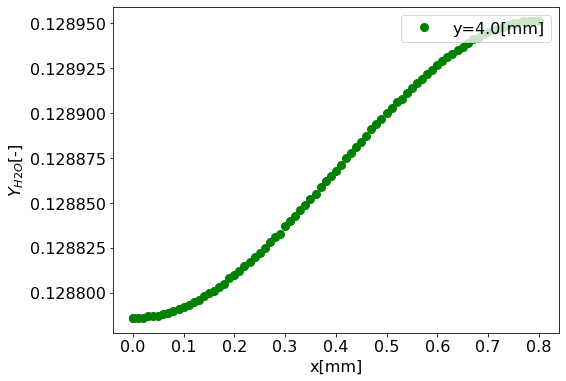

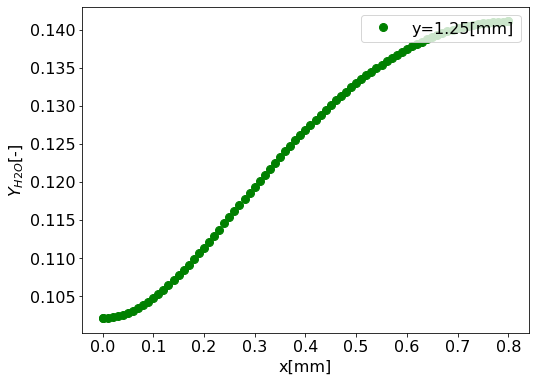

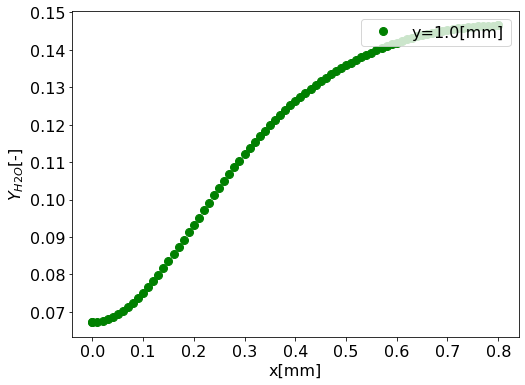

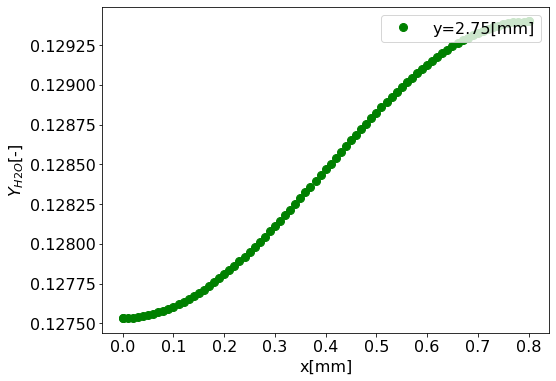

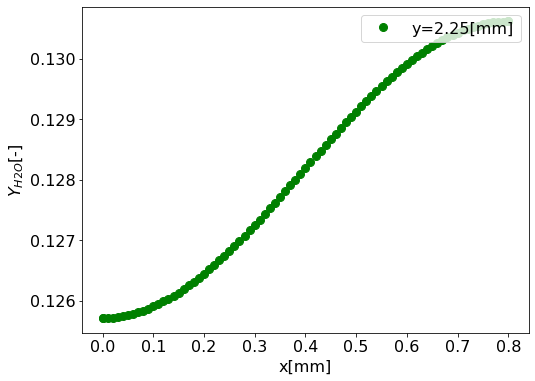

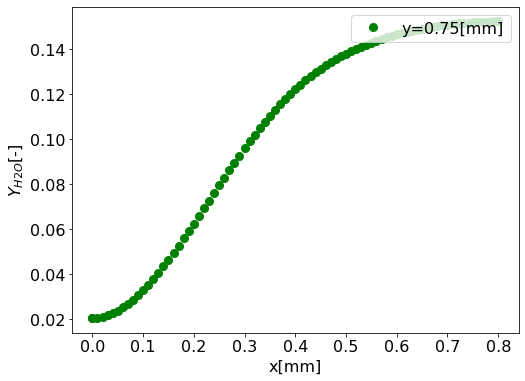

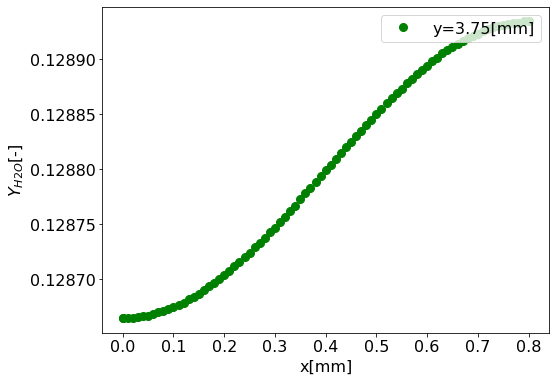

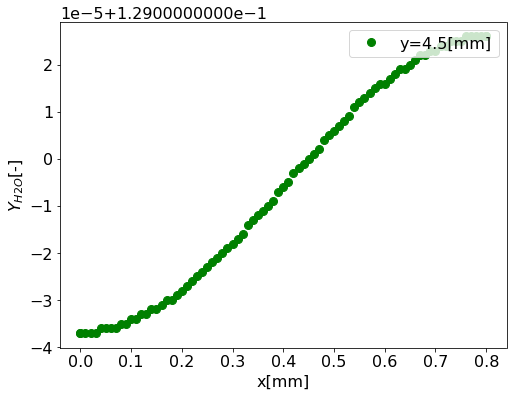

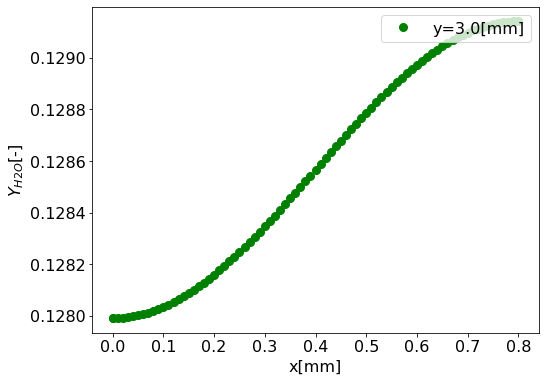

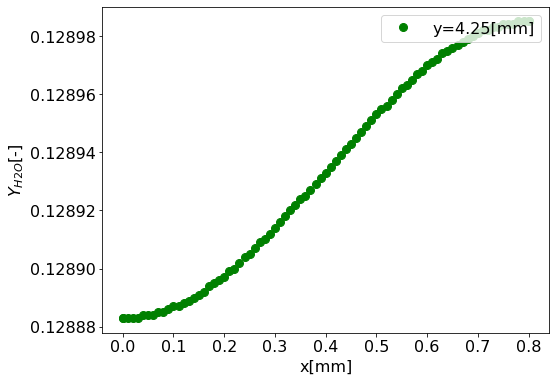

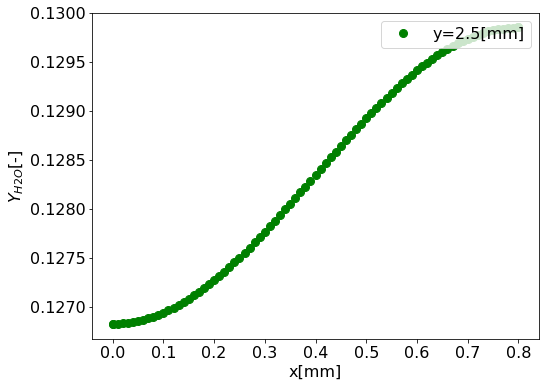

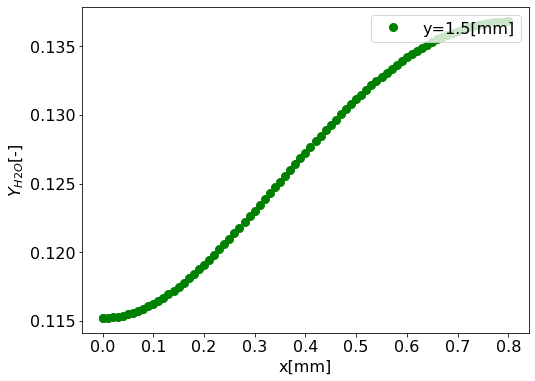

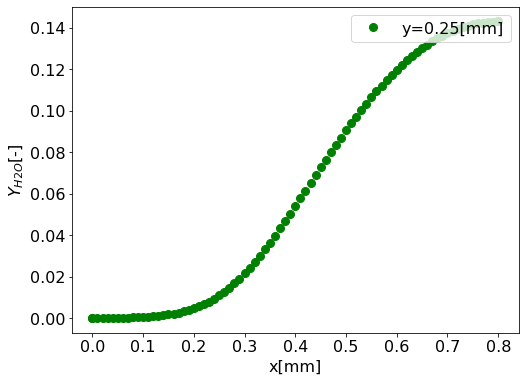

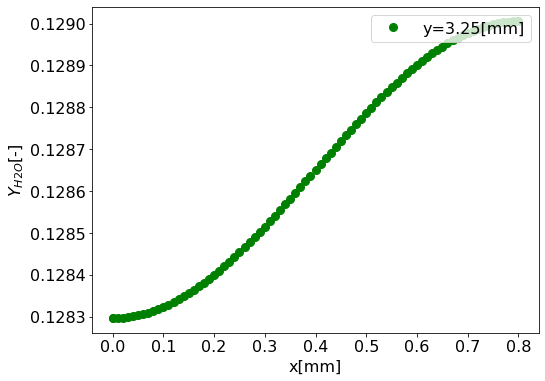

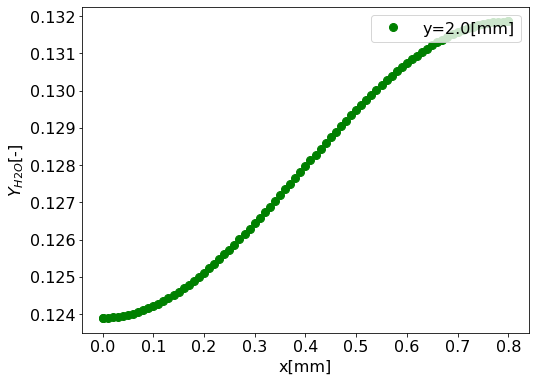

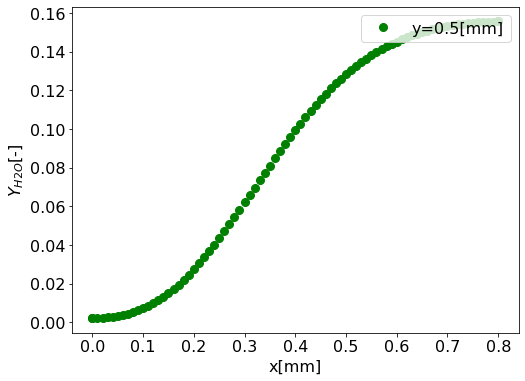

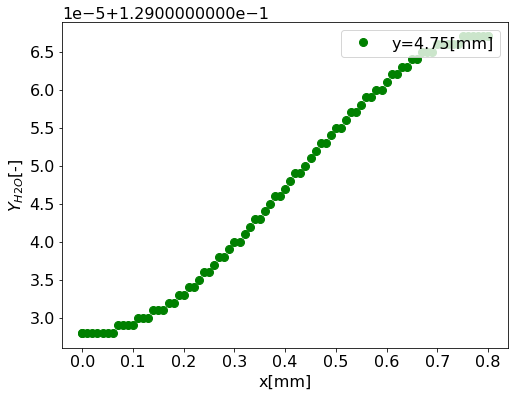

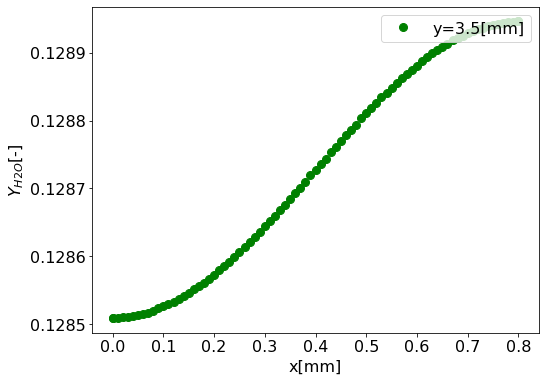

In [40]:
make_plots_massfraction("H2O","/home/cristopher/Python_scripts_for_computing_physical_quantities/data 2D burner/data 2D burner hydrogen/")

# Funtions for computing mean and variance of a list of values

In [30]:
def mean_value(values=None):
    ''' 
    list::values: list containing the values from where the mean value will be computed
    '''
    '''start checks'''
    if (values==None or values==[]):
        raise ValueError("argument must be a non-empty list")
    elif(type(values)==str):
        raise TypeError("argument must be a list or a number")
    elif(type(values)==float or type(values)==int):
        values=[values]
    n = len(values)
    if n>1:
        return (n-1)*mean_value(values[:n-1])/n + values[n-1]/n
    else:
        return values[0]

def variance(values):
    mean = mean_value(values)
    variance = 0
    for i in range(0,len(values)):
        variance+=(values[i]-mean)**2
    return variance/len(values)